In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import timm
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.v2 as v2
import torchvision.ops as ops

from transformers import AutoModel, AutoTokenizer, AutoImageProcessor
from torch.utils.data import DataLoader
from einops import rearrange

2025-05-11 08:11:00.099494: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-11 08:11:00.112345: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746951060.128374  728977 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746951060.133226  728977 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-11 08:11:00.149431: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
#### General Parameters ####

IMAGE_SIZE = 518
PATCH_SIZE = 14
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

VIT_BASE_FREEZE_LAYERS = 8
BERT_FREEZE_LAYERS = 8
MODEL_DIM = 768
LR_BERT = 8e-5
LR_VIT = 5e-4

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32

In [4]:
class TextEncoder(nn.Module):
    def __init__(self):
        super(TextEncoder, self).__init__()
        
        self.bert = AutoModel.from_pretrained("microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext")
        self.tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext")
        
        for name, param in self.bert.named_parameters():
            if 'encoder.layer' in name:
                layer_num = int(name.split('encoder.layer.')[1].split('.')[0])
                if layer_num < BERT_FREEZE_LAYERS:
                    param.requires_grad = False
    
    def tokenize(self, texts):
        encoded_text = self.tokenizer(texts, padding=True, truncation=True, 
                                      return_tensors="pt", max_length=256).to(device=DEVICE)

        return encoded_text
    
    def forward(self, encoded_text):
        outputs = self.bert(**encoded_text)
        
        return outputs.last_hidden_state.to(dtype=torch.float32)

In [5]:
class ViTBase(nn.Module):
    def __init__(self):
        super(ViTBase, self).__init__()

        self.model = AutoModel.from_pretrained('microsoft/rad-dino')
        self.processor = AutoImageProcessor.from_pretrained('microsoft/rad-dino')
        
        for name, param in self.model.named_parameters():
            if 'encoder.layer' in name:
                layer_num = int(name.split('encoder.layer.')[1].split('.')[0])
                if layer_num < VIT_BASE_FREEZE_LAYERS:
                    param.requires_grad = False

    def forward(self, imgs):
        outputs = self.model(**imgs)
        outputs = outputs.last_hidden_state
        
        return outputs[:, 1:, ...]

In [6]:
class VisionDecoder(nn.Module):
    def __init__(
        self,
        embed_dim=MODEL_DIM,
        num_heads=8,
        dropout=0.1,
        output_hidden=1024,
        output_dim=512,
    ):
        super(VisionDecoder, self).__init__()

        self.cross_attention = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(
                d_model=embed_dim,
                nhead=num_heads,
                dim_feedforward=int(embed_dim * 3.0),
                activation="gelu",
                batch_first=True,
            ),
            num_layers=6,
        )

    def forward(self, img_features, T):
        X = self.cross_attention(img_features, T)

        return X

In [7]:
class VisionOutputHead(nn.Module):
    def __init__(
        self,
        in_dim=MODEL_DIM,
    ):
        super(VisionOutputHead, self).__init__()

        self.binary_output = nn.Sequential(
            *[
                nn.Linear(in_features=in_dim, out_features=in_dim // 4),
                nn.GELU(),
                nn.Linear(in_features=in_dim // 4, out_features=1),
            ]
        )

        self.count_output = nn.Sequential(
            *[
                nn.Linear(in_features=in_dim, out_features=in_dim // 4),
                nn.GELU(),
                nn.Linear(in_features=in_dim // 4, out_features=1),
            ]
        )

    def forward(self, X):
        binary = self.binary_output(X)
        count = self.count_output(X)

        return binary, count

In [8]:
class MultiModalViT(nn.Module):
    def __init__(
        self,
        embed_dim=MODEL_DIM,
        output_dim=MODEL_DIM,
    ):
        super(MultiModalViT, self).__init__()

        self.text_encoder = TextEncoder()
        self.encoder = ViTBase()
        self.decoder = VisionDecoder(embed_dim=embed_dim, output_dim=output_dim)
        self.output = VisionOutputHead(in_dim=output_dim)

    def forward(self, imgs, texts):
        T = self.text_encoder.tokenize(texts)
        T = self.text_encoder(T)

        features = self.encoder({'pixel_values': imgs})
        decoded_out = self.decoder(features, T)
        
        binary, count = self.output(decoded_out)
        return binary.squeeze(-1), count.squeeze(-1)

In [9]:
model = MultiModalViT().to(DEVICE)
model.load_state_dict(torch.load('checkpoints/vit_dinopt_epoch50.pt', weights_only=True))

print(f"Total Model Parameters: ~{sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6:.2f}mil")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Total Model Parameters: ~132.57mil


In [15]:
import os
import csv
import glob
import matplotlib.pyplot as plt

from data_utils import (
    Datapoint,
    SegmentationDataset,
    generate_labels,
    normalize_images,
    find_mask_center,
)

from typing import List
from PIL import Image


label_map = [
    ("left lung", [44, 47]),
    ("right lung", [45, 46, 48]),
    ("left ribs", list(range(53, 65))),
    ("right ribs", list(range(65, 77))),
    ("vertebraes", list(range(92, 117))),
]

with open("data/training/labels.csv", "r", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        skip_row = False
        for struct in ["lung", "rib", "vertebrae"]:
            if struct in row["name"]:
                skip_row = True

        if not skip_row:
            label_map.append((row["name"].replace("_", " "), [int(row["id"]) - 1]))

matches = glob.glob("data/training/all_ap_pa/**/*.npy", recursive=True)
data: List[Datapoint] = []
view_map = {
    "AP": "anteroposterior",
    "LAP": "anteroposterior",
    "RAP": "anteroposterior",
    "PA": "posteroanterior",
    "LPA": "posteroanterior",
    "RPA": "posteroanterior",
    "LLAT": "left lateral",
    "RLAT": "right lateral",
}

for i, file_path in enumerate(matches):
    print(file_path, i / len(matches) * 100)

    view = view_map[os.path.basename(file_path).rstrip("_labels.npy")]
    name = file_path.rstrip("_labels.npy")

    images = np.load(file_path)[1:]
    images = v2.Resize(
        size=(IMAGE_SIZE, IMAGE_SIZE), interpolation=v2.InterpolationMode.BICUBIC, antialias=True
    ).forward(torch.tensor(images)).numpy()
    
    base = np.asarray(Image.open(f"{name}_base.png").convert("RGB").getdata())
    base = rearrange(
        torch.tensor(base / 255, dtype=torch.float32),
        "(h w) c -> c h w",
        h=256,
    )
    base = v2.Resize(
        size=(IMAGE_SIZE, IMAGE_SIZE), interpolation=v2.InterpolationMode.BICUBIC, antialias=True
    ).forward(base)
    base = v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]).forward(base).numpy()

    for _, (structure, idxs) in enumerate(label_map):
        try:
            mask: np.ndarray = sum([images[i] for i in idxs])
        except IndexError:
            continue

        if np.count_nonzero(mask) == 0:
            continue

        p1 = np.percentile(mask.flatten(), [10])
        mask = (mask > p1).astype(np.float32)

        center = find_mask_center(rearrange(mask * 255, "c h w -> h w c"))
        if center is None or center[1] < 50.0 or center[1] > 200.0:
            continue

        binary, count = generate_labels(mask, patch_size=PATCH_SIZE)
        data.append(
            Datapoint(
                base_img=base,
                gt_mask=mask,
                label_binary=binary,
                label_count=count,
                mask_center=center,
                structure=structure,
                view=view,
            )
        )

train_dataset = SegmentationDataset(data)

data/training/all_ap_pa/s1134/PA_labels.npy 0.0
data/training/all_ap_pa/s1134/AP_labels.npy 0.20161290322580644
data/training/all_ap_pa/s1321/PA_labels.npy 0.4032258064516129
data/training/all_ap_pa/s1321/AP_labels.npy 0.6048387096774194
data/training/all_ap_pa/s0750/PA_labels.npy 0.8064516129032258
data/training/all_ap_pa/s0750/AP_labels.npy 1.0080645161290323
data/training/all_ap_pa/s0488/PA_labels.npy 1.2096774193548387
data/training/all_ap_pa/s0488/AP_labels.npy 1.411290322580645
data/training/all_ap_pa/s0715/PA_labels.npy 1.6129032258064515
data/training/all_ap_pa/s0715/AP_labels.npy 1.8145161290322582
data/training/all_ap_pa/s0754/PA_labels.npy 2.0161290322580645
data/training/all_ap_pa/s0754/AP_labels.npy 2.217741935483871
data/training/all_ap_pa/s0941/PA_labels.npy 2.4193548387096775
data/training/all_ap_pa/s0941/AP_labels.npy 2.620967741935484
data/training/all_ap_pa/s0652/PA_labels.npy 2.82258064516129
data/training/all_ap_pa/s0652/AP_labels.npy 3.024193548387097
data/trainin

In [16]:
matches = glob.glob("data/evaluation/**/*.npy", recursive=True)
mask_transforms = v2.Compose(
    [
        v2.Lambda(lambda x: torch.tensor(x, dtype=torch.float32)),
        v2.Resize(
            size=(IMAGE_SIZE, IMAGE_SIZE), interpolation=v2.InterpolationMode.BICUBIC, antialias=True
        ),
    ]
)

eval_data = []
for i, file_path in enumerate(matches):
    print(file_path)

    name = file_path.rstrip("_mask.npy")

    base = np.asarray(Image.open(f"{name}.png").convert("RGB").getdata())
    base = rearrange(
        torch.tensor(base / 255, dtype=torch.float32),
        "(h w) c -> c h w",
        h=200,
    )
    base = (base - base.min()) / (base.max() - base.min())
    base = v2.Resize(
        size=(IMAGE_SIZE, IMAGE_SIZE), interpolation=v2.InterpolationMode.BICUBIC, antialias=True
    ).forward(base)
    base = v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]).forward(base).numpy()

    masks = rearrange(np.load(file_path), "h w b -> b 1 h w")
    masks = mask_transforms.forward(masks).numpy()

    for i, structure in enumerate(["right lung", "left lung", "heart"]):
        p1 = np.percentile(masks[i].flatten(), [5])
        binary, count = generate_labels(mask=(masks[i] > p1), patch_size=PATCH_SIZE)
        eval_data.append(
            Datapoint(
                base_img=base,
                gt_mask=masks[i],
                label_binary=binary,
                label_count=count,
                mask_center=np.array([0, 0]),
                structure=structure,
                view=view_map["AP"],
            )
        )


eval_dataset = SegmentationDataset(eval_data)

data/evaluation/JPCLN142_mask.npy
data/evaluation/JPCLN135_mask.npy
data/evaluation/JPCLN131_mask.npy
data/evaluation/JPCLN143_mask.npy
data/evaluation/JPCLN133_mask.npy
data/evaluation/JPCLN141_mask.npy
data/evaluation/JPCLN139_mask.npy
data/evaluation/JPCLN130_mask.npy
data/evaluation/JPCLN144_mask.npy
data/evaluation/JPCLN138_mask.npy
data/evaluation/JPCLN137_mask.npy
data/evaluation/JPCLN140_mask.npy
data/evaluation/JPCLN134_mask.npy
data/evaluation/JPCLN136_mask.npy
data/evaluation/JPCLN132_mask.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0459011..0.99777246].


humerus left in a posteroanterior view xray
Dataset Size: 5683


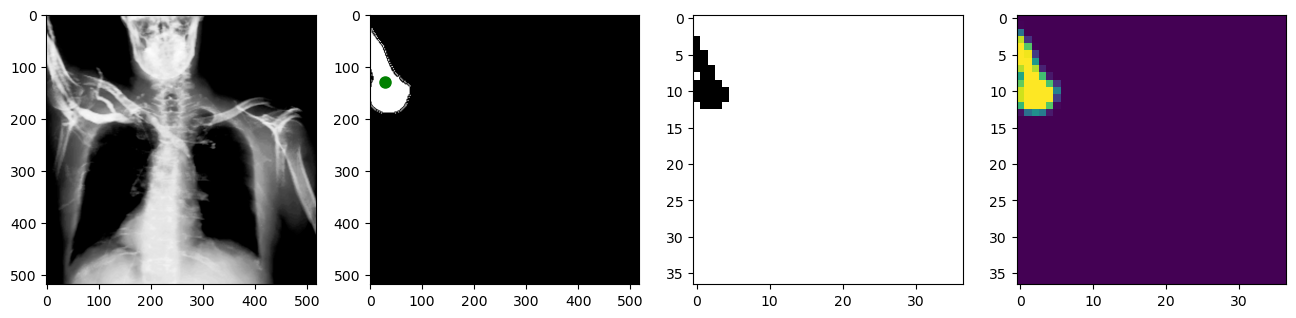

In [21]:
import matplotlib.pyplot as plt

prompt, base, binary, count, mask, center = train_dataset.get_random()

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16, 16))
axs[0].imshow(rearrange(base.numpy(), "c h w -> h w c"), cmap="gray")
axs[1].imshow(rearrange(mask.numpy(), "c h w -> h w c"), cmap="gray")
axs[1].plot(center[0], center[1], "og", markersize=8)
axs[2].imshow(binary.numpy(), cmap="binary", vmin=0, vmax=1)
axs[3].imshow(count.numpy())

print(train_dataset.sentence_from_tensor(prompt))
print(
    f"Dataset Size: {len(train_dataset)}"
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True
)

eval_loader = DataLoader(
    dataset=eval_dataset,
    batch_size=4,
    shuffle=True,
    pin_memory=True
)

In [22]:
def training(
    model: MultiModalViT,
    train_loader,
    eval_loader,
    epochs=20,
):
    model.to(DEVICE)

    text_encoder_params = {
        "params": [p for p in model.text_encoder.parameters() if p.requires_grad]
    }
    other_params = {
        "params": [
            p
            for p in model.parameters()
            if p.requires_grad
            and not any(param is p for param in model.text_encoder.parameters())
        ]
    }

    optimizer = optim.AdamW(
        [
            {**text_encoder_params, "lr": LR_BERT},
            {**other_params, "lr": LR_VIT},
        ]
    )

    for i in range(epochs):
        model.train()
        train_loss = 0.0

        for j, (prompt, base, binary_label, count_label, _, _) in enumerate(
            train_loader
        ):
            texts = []
            for z in range(prompt.shape[0]):
                texts.append(train_dataset.sentence_from_tensor(prompt[z]))

            base = base.to(DEVICE, dtype=torch.float32)
            binary_label = binary_label.flatten(start_dim=1).to(
                DEVICE, dtype=torch.float32
            )
            count_label = count_label.flatten(start_dim=1).to(
                DEVICE, dtype=torch.float32
            )

            #############################

            binary, count = model(base, texts)
            binary_prob = F.sigmoid(binary)

            bce_loss = ops.focal_loss.sigmoid_focal_loss(
                binary, binary_label, gamma=2.0, alpha=0.55, reduction="mean"
            )
            mse_loss = F.mse_loss(count, count_label)

            confidence = torch.max(binary_prob, 1 - binary_prob)
            diff = torch.abs(binary_prob - (count / PATCH_SIZE**2))
            consistency_loss = (diff * confidence).mean()

            loss = bce_loss + 0.6 * mse_loss + 0.8 * consistency_loss
            train_loss += loss.item()
            if j % 10 == 0:
                print(
                    f"Epoch {i}; Batch {j} : bce={bce_loss.item():.4f}, mse={mse_loss.item():.4f}, total={loss.item():.4f}"
                )

            optimizer.zero_grad()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for j, (prompt, base, binary_label, count_label, _, _) in enumerate(
                eval_loader
            ):
                texts = []
                for z in range(prompt.shape[0]):
                    texts.append(eval_dataset.sentence_from_tensor(prompt[z]))

                base = base.to(DEVICE, dtype=torch.float32)
                binary_label = binary_label.flatten(start_dim=1).to(
                    DEVICE, dtype=torch.float32
                )
                count_label = count_label.flatten(start_dim=1).to(
                    DEVICE, dtype=torch.float32
                )

                #############################

                binary, count = model(base, texts)
                binary_prob = F.sigmoid(binary)

                bce_loss = ops.focal_loss.sigmoid_focal_loss(
                    binary, binary_label, gamma=2.0, alpha=0.55, reduction="mean"
                )
                mse_loss = F.mse_loss(count, count_label)

                confidence = torch.max(binary_prob, 1 - binary_prob)
                diff = torch.abs(binary_prob - (count / PATCH_SIZE**2))
                consistency_loss = (diff * confidence).mean()

                loss = bce_loss + 0.6 * mse_loss + 0.8 * consistency_loss
                val_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss /= len(eval_loader)

        print(
            f"Epoch {i}; : training loss={train_loss:.4f}, validation loss={val_loss:.4f}"
        )

        if (i + 1) % 2 == 0:
            torch.save(model.state_dict(), f"checkpoints/vit_dinopt_epoch{i+1}.pt")

In [23]:
training(
    model=model, train_loader=train_loader, eval_loader=eval_loader, epochs=50
)

Epoch 0; Batch 0 : bce=0.0261, mse=664.7268, total=398.8631
Epoch 0; Batch 10 : bce=0.0346, mse=963.7490, total=578.2887
Epoch 0; Batch 20 : bce=0.0365, mse=1018.5950, total=611.1945
Epoch 0; Batch 30 : bce=0.0323, mse=887.9467, total=532.8024
Epoch 0; Batch 40 : bce=0.0299, mse=732.9669, total=439.8109
Epoch 0; Batch 50 : bce=0.0369, mse=1021.6796, total=613.0463
Epoch 0; Batch 60 : bce=0.0265, mse=701.0289, total=420.6466
Epoch 0; Batch 70 : bce=0.0374, mse=1040.2178, total=624.1706
Epoch 0; Batch 80 : bce=0.0383, mse=1081.5732, total=648.9837
Epoch 0; Batch 90 : bce=0.0341, mse=992.5124, total=595.5435
Epoch 0; Batch 100 : bce=0.0292, mse=829.1759, total=497.5366
Epoch 0; Batch 110 : bce=0.0317, mse=889.4593, total=533.7088
Epoch 0; Batch 120 : bce=0.0294, mse=788.7004, total=473.2506
Epoch 0; Batch 130 : bce=0.0386, mse=1117.8210, total=670.7324
Epoch 0; Batch 140 : bce=0.0217, mse=526.6783, total=316.0294
Epoch 0; Batch 150 : bce=0.0354, mse=991.1834, total=594.7465
Epoch 0; Batch

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08990586..1.0198674].


Loss: 1028.4640
Prompt: heart in an anteroposterior view xray


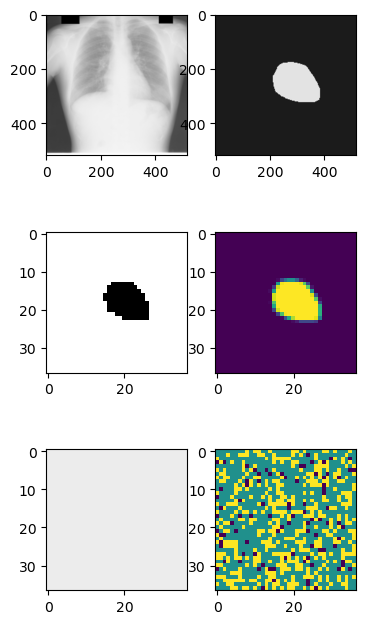

In [13]:
import random


model.eval()

with torch.no_grad():
    prompt, base, binary_label, count_label, mask, _ = eval_dataset[
        random.randrange(0, len(eval_dataset))
    ]

    texts = [eval_dataset.sentence_from_tensor(prompt)]
    # texts = ["hip in a left lateral view xray"]

    base = base.unsqueeze(0).to(DEVICE, dtype=torch.float32)
    binary_label = (
        binary_label.unsqueeze(0).flatten(start_dim=1).to(DEVICE, dtype=torch.float32)
    )
    count_label = (
        count_label.unsqueeze(0).flatten(start_dim=1).to(DEVICE, dtype=torch.float32)
    )

    #############################

    binary, count = model(base, texts)
    binary_prob = torch.sigmoid(binary)

    bce_loss = ops.focal_loss.sigmoid_focal_loss(
        binary, binary_label, gamma=2.5, alpha=0.6, reduction="mean"
    )
    mse_loss = F.mse_loss(count, count_label)

    confidence = torch.max(binary_prob, 1 - binary_prob)
    diff = torch.abs(binary_prob - (count / PATCH_SIZE**2))
    consistency_loss = (diff * confidence).mean()

    loss = bce_loss + 0.4 * mse_loss + 0.5 * consistency_loss
    print(f"Loss: {loss.item():.4f}")

    patches = IMAGE_SIZE // PATCH_SIZE
    binary = F.sigmoid(binary).reshape(patches, patches)
    count = count.reshape(patches, patches)
    binary_label = binary_label.reshape(patches, patches)
    count_label = count_label.reshape(patches, patches)


fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(4, 8))
axs[0, 0].imshow(
    rearrange((base[0].cpu().detach().numpy() + 1.0) / 2.0, "c h w -> h w c")
)
axs[0, 1].imshow(rearrange(mask.cpu().detach().numpy(), "c h w -> h w c"), cmap="gray")
axs[1, 0].imshow(
    binary_label.cpu().detach().numpy(),
    cmap="binary",
    vmin=0,
    vmax=1,
)
axs[1, 1].imshow(count_label.cpu().detach().numpy())
axs[2, 0].imshow(
    binary.cpu().detach().numpy(),
    cmap="binary",
    vmin=0,
    vmax=1,
)
axs[2, 1].imshow(count.cpu().detach().numpy())

print(f"Prompt: {texts[0]}")